
### 빵형의 음원추천 알고리즘 정리용 페이지
 
 GTZAN dataset : https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification
 기반으로 삼은 코드 : https://www.kaggle.com/andradaolteanu/work-w-audio-data-visualise-classify-recommend
 
anaconda promtp 에서 pip install kaggle
먼저 치셔야 아래 로직들 적용 가능합니다.

### 데이터셋 다운로드 파트
    우리한테는 그렇게까지 필요없다고 생각하는 부분.
    why? 직접 받아온 데이터를 기반으로 업데이트 해야하기 때문

- 케글과 연동하기
import os
os.environ['KAGGLE_USERNAME'] = '너꺼 케글 아이디'
os.environ['KAGGLE_KEY'] = '케글 setting들어가서 token발급 받으면 제공받는 토큰값'
-> 케클 account 들어가서 token 발급받기 하시면 jason형태로 아이디, kaggle key 값 받을 수 있습니다.

- 케글에 제공되어진 폴더 다운로드 받기
!kaggle datasets download -d andradaolteanu/gtzan-dataset-music-genre-classification
- 다운받은 폴더 압축 풀어주는 로직
!unzip -q gtzan-dataset-music-genre-classification.zip

** 데이터 폴더 안에 저장된 친구들
1. genres_original : 임의로 구성된 10개의 장르별 폴더 -> .wav 웨이브 형태의 음원 파일
2. img_original : 동일하게 구성된 10개의 장르별 폴더 - 각 음원들의 멜스펙토그램 사진
3. 30초 단위의 오디오 feature 분석한 csv파일
4. 3초 단위의 상기 동일한 csv파일

일단 다운받아서 확인해보는 것이 좋겠다고 생각이 듭니다~

In [1]:
# 상기 로직 작성해보는 칸
import os
os.environ['KAGGLE_USERNAME'] = "parkym"
os.environ['KAGGLE_KEY'] = "e0b3786fd5179a129baa8bfbdba41d42"

In [2]:
!kaggle datasets download -d andradaolteanu/gtzan-dataset-music-genre-classification

gtzan-dataset-music-genre-classification.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
# Window OS에서 사용되는 unzip 방식
import zipfile  # 내장 라이브러리

zip_file=zipfile.ZipFile("gtzan-dataset-music-genre-classification.zip")  # zip 상태의 파일 위치
zip_file.extractall() # () 안에 경로 쓰면 그 위치로 압축 해제되고, 비워두면 현재 폴더에 저장됩니다.

In [4]:
!unzip -q gtzan-dataset-music-genre-classification.zip
# 얘는 mac OS 에서 사용되는 듯합니다.

'unzip'은(는) 내부 또는 외부 명령, 실행할 수 있는 프로그램, 또는
배치 파일이 아닙니다.


### 오디오 파일 이해하기!
(프로젝트 연관성을 없지만 기본적으로 라이브러리는 설치해야 함)

- y: 소리가 떨리는 세기(진폭)를 시간 순서대로 나열한 것
- Sampling rate(sr) : 1초당 샘플의 개수, 단위 Hz 도는 kHz

librosa 라는 라이브러리를 사용한다는 듯

librosa 설치하기
    !pip install librosa
    import librosa

하고 시작해봅시다 우리

In [5]:
import librosa

y, sr = librosa.load('./Data/genres_original/reggae/reggae.00036.wav')  # 파일 경로~
# 한개씩 비교하니까 for문으로 돌리면 될듯 합니다.

print(y)              # 음악을 숫자로 읽어오는 것
print(len(y))         # 음악을 숫자로 바꾼 후 길이
print('Sampling rate (kHz): %d' % sr)   
print('Audio length (seconds): %.2f' % (len(y) / sr))     # 오디오가 몇초 짜리인지 알 수 있는 로직

C:\Users\smhrd\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


[0.02072144 0.04492188 0.05422974 ... 0.06912231 0.08303833 0.08572388]
661794
Sampling rate (kHz): 22050
Audio length (seconds): 30.01


파이썬에서 음악을 들어봅시다.
    IPython.display 라는 라이브러리를 통해 가능하다고 합니다.

In [6]:
import IPython.display as ipd

ipd.Audio(y, rate=sr)

# 이렇게 음원을 들을 수 있습니다.

2D 음파 그래프 - pyplot으로 그려집니다.
(프로젝트 연관성 거의 없는듯?)

필요한 라이브러리
matplotlib.pyplot by plt
librosa.display
가 있습니다.

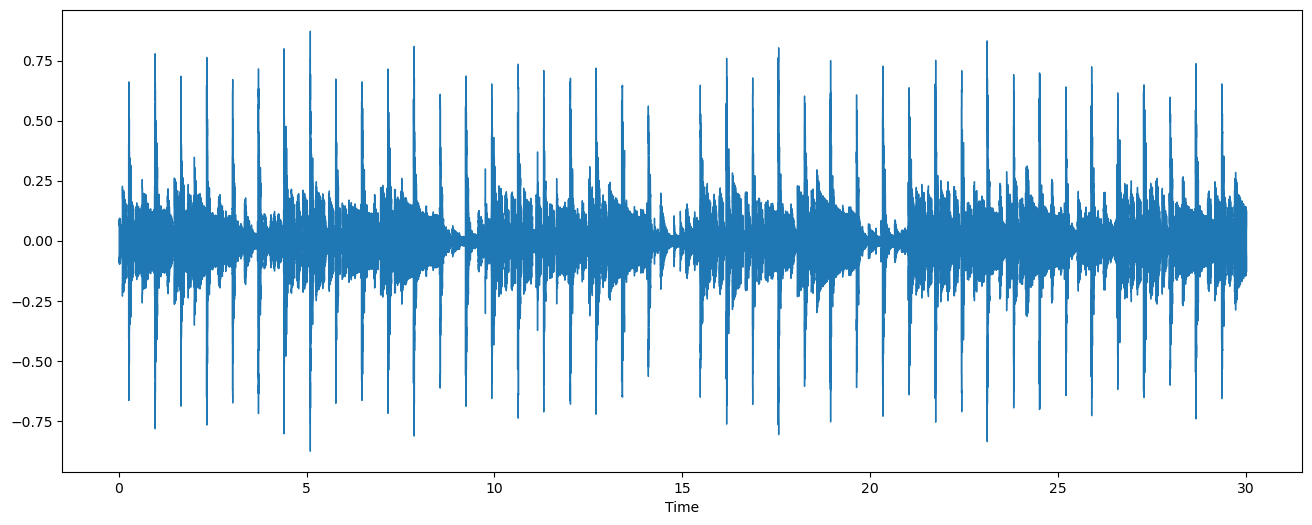

In [7]:
import matplotlib.pyplot as plt
import librosa.display

plt.figure(figsize=(16,6))         
librosa.display.waveshow(y=y, sr=sr)
# 현재 설치된 librosa 버전에서는 waveplot()이 아닌 waveshow()를 사용하면 됩니다.
#이 친구를 통해서 그래프를 보여줄 수 있다고 합니다. 가로=시간, y축=오디오 세기
plt.show()

Fourier Transform
    - 시간영역 데이터를 주파수 영역으로 변경하는 작업
    - y축 : 주파수 (로그 스케일)
    - color축 : 데시벨 (진폭)
    
음원 분석을 보다 용이하게 만드는 작업이라고 합니다.
다만 여기서 만들어진 그래프를 보고 이해하기는 많이 어렵다고 합니다.

(1025, 1293)


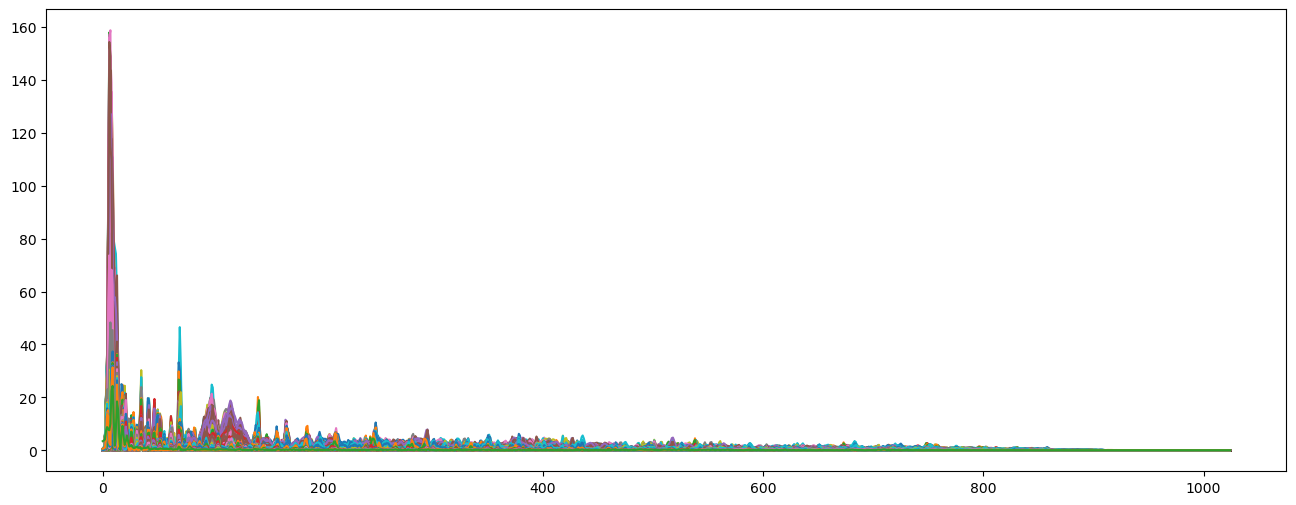

In [8]:
import numpy as np

D = np.abs(librosa.stft(y, n_fft=2048, hop_length=512)) 
#librosa.stft 를 통해서 변환을 하고 n_fft 는 윈도우 사이즈?? 라고 하네요 ㅎㅎ;;

print(D.shape)

plt.figure(figsize=(16,6))
plt.plot(D)
plt.show()

Spectogram
    - 시간에 따른 신호 주파수의 스팩트럼 그래프
    - 다른 이름 : Sonographs, Voiceprints, Voicegrams

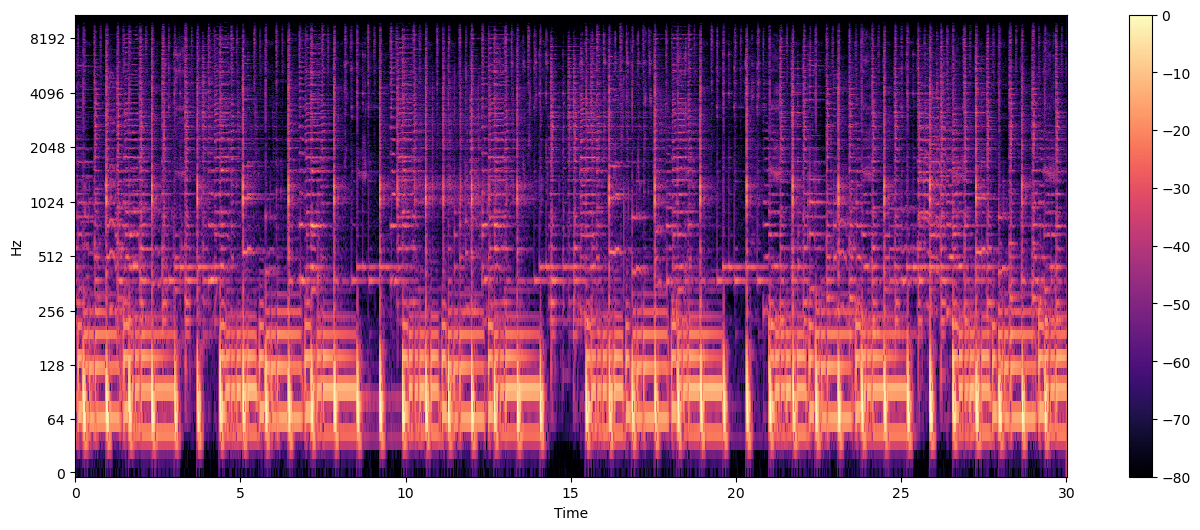

In [9]:
DB = librosa.amplitude_to_db(D, ref=np.max)   # D = 데시벨을 의미.

plt.figure(figsize=(16,6))
librosa.display.specshow(DB, sr=sr, hop_length=512, x_axis='time', y_axis='log')
plt.colorbar()
plt.show()

# 보다 정론된 데이터 그래프가 나오지만 여전히 인간히 알아보기 어렵다.

### Mel Spectogram 만들기
Mel Spectogram
    (인간이 이해하기 힘든) Spectogram의 y축을 Mel Scale로 변환한 것 (Non-linear transformation)
    Mel Scale : https://newsight.tistory.com/294 
    주소로 들어가면 음성인식에 관련된 기초에 대해서 알 수 있습니다.
    
    -> 즉 log 스케일이고 인간이 이해할 수 있는 진폭형 데이터를 보여준다는 의미.

C:\Users\smhrd\AppData\Local\Temp\ipykernel_1376\2102450683.py:1: FutureWarning: Pass y=[0.02072144 0.04492188 0.05422974 ... 0.06912231 0.08303833 0.08572388] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=sr)  # 안되면 melspectogram으로 바꿔주세요.


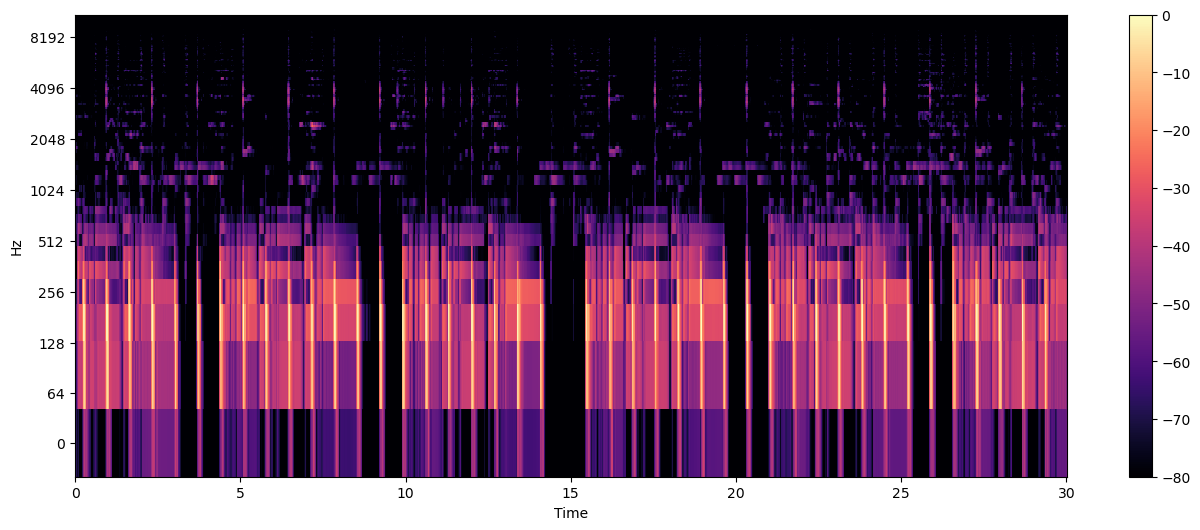

In [10]:
S = librosa.feature.melspectrogram(y, sr=sr)  # 안되면 melspectogram으로 바꿔주세요.
S_DB = librosa.amplitude_to_db(S, ref=np.max)

plt.figure(figsize=(16,6))
librosa.display.specshow(S_DB, sr=sr, hop_length=512, x_axis='time', y_axis='log')
plt.colorbar()
plt.show()

# 여기서 만들어진 그래프 형태를 가장 많이 쓰인다고 합니다.

C:\Users\smhrd\AppData\Local\Temp\ipykernel_1376\2443666277.py:5: FutureWarning: Pass y=[ 0.00167847  0.00393677  0.00320435 ... -0.00067139 -0.00082397
 -0.00091553] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr=sr)


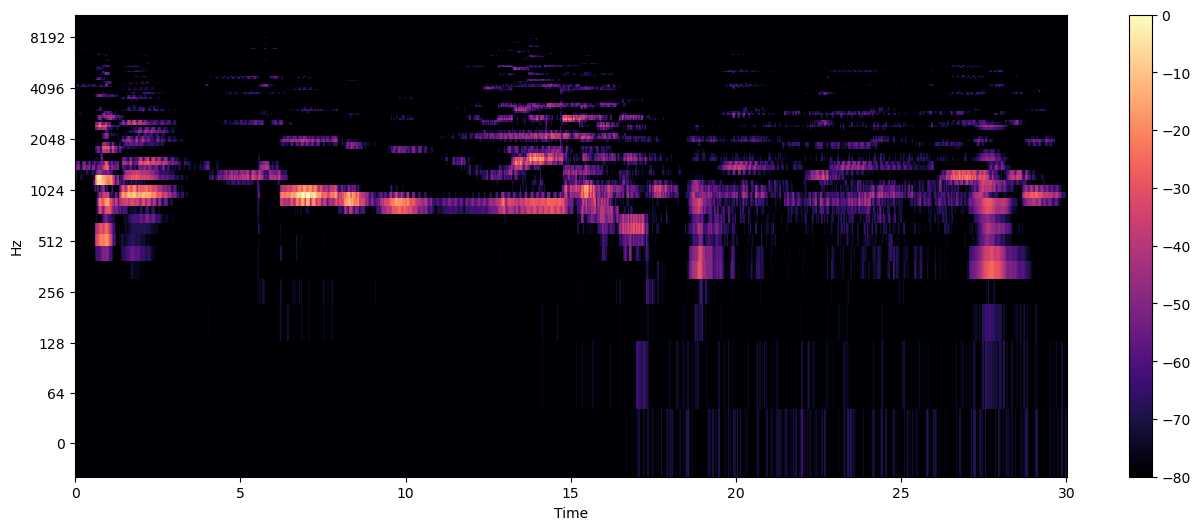

In [11]:
# 다른 음악과 비교해 봅시다.
y, sr = librosa.load('Data/genres_original/classical/classical.00036.wav')
y, _ = librosa.effects.trim(y)

S = librosa.feature.melspectrogram(y, sr=sr)
S_DB = librosa.amplitude_to_db(S, ref=np.max)
plt.figure(figsize=(16,6))
librosa.display.specshow(S_DB, sr=sr, hop_length=512, x_axis='time', y_axis='log')
plt.colorbar()
plt.show()

Ex) 특정 파일 Mel Spectogram 하는 경우
    y,sr = librosa.load('불러올 음원 파일 이름.wav')
    y, _ = librosa.effects.trim(y)
    여기만 다르고 아래는 동일하게 만들어서 Mel Spectogram 만들 수 있다.
    S = librosa.featire.melspectrogram(y, sr=sr)
    S_DB = librosa.amplitude_to_db(S, ref=np.max)
    plt.figure(figsize=(16,6))
    librosa.display.specshow(S_DB, sr=sr, hop_length=512, x_axis='time', y_axis='log')
    plt.colorbar()
    plt.show()
    각각의 음악의 데시벨, 진폭에 따라 다르게 만들어집니다.

### 오디오 특성 추출하기 (Audio Feature Extraction)

(그렇게까진 필요성이 느껴지지 않는 파트.. 아래 보면 bpm구하는 방법 나와있슴다)

- bpm 정보가 없을 때 bpm이 몇인지 예측 할 수가 있습니다~

- zero crossing rate 자주 쓰인다고 합니다. 정확한 의미는 무엇일까요;;

In [12]:
# Tempo(BPM) 구하는 로직
tempo, _ = librosa.beat.beat_track(y, sr=sr)
print(tempo)

107.666015625


C:\Users\smhrd\AppData\Local\Temp\ipykernel_1376\3963689926.py:2: FutureWarning: Pass y=[ 0.00167847  0.00393677  0.00320435 ... -0.00067139 -0.00082397
 -0.00091553] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  tempo, _ = librosa.beat.beat_track(y, sr=sr)


In [13]:
# Zero Crossing Rate : 음파가 양에서 음으로 or 음에서 양으로 바뀌는 비율
zero_crossings = librosa.zero_crossings(y, pad=False)

print(zero_crossings)
print(sum(zero_crossings))


[False False False ... False False False]
39405


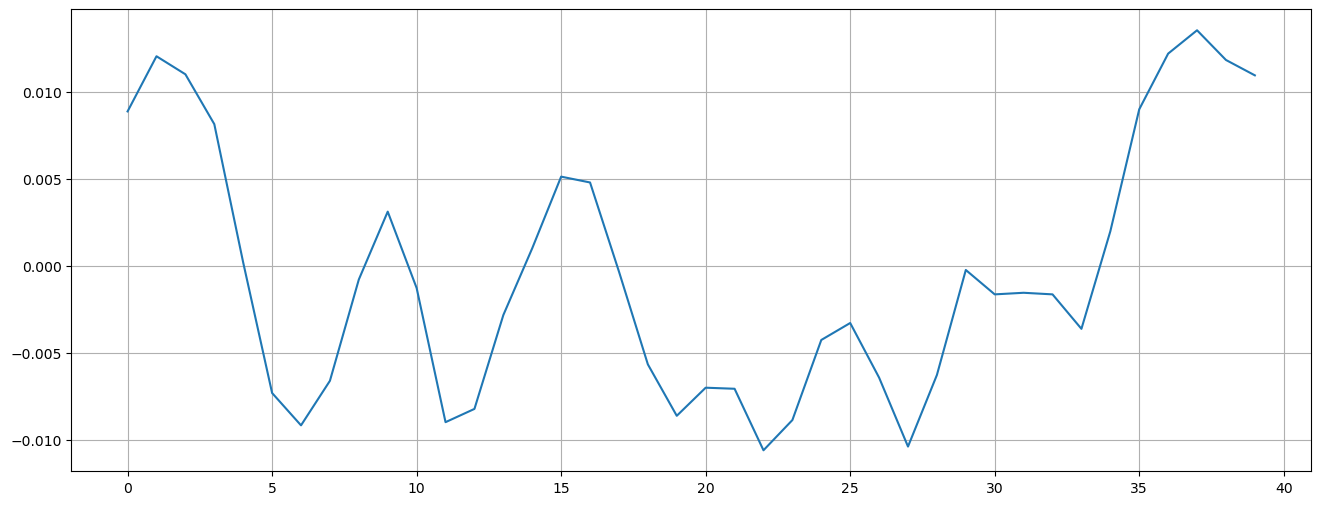

In [14]:
# 용도에 대해서는 확실히 인지를 못하겠습니다. 특정 기간동안 몇회 crossing이 발생했는지 확인하는 방법
n0 = 9000
n1 = 9040

plt.figure(figsize=(16,6))
plt.plot(y[n0:n1])
plt.grid()
plt.show()
# 하면 됩니다.

In [15]:
zero_crossings = librosa.zero_crossings(y[n0:n1], pad=False)
print(sum(zero_crossings))

6


Harmonic and Percussive Components
    Harmonics : 사람의 귀로 구분할 수 없는 특징들 (음악의 색깔)
    Percussives : 리듬과 감정을 나타내는 충격파

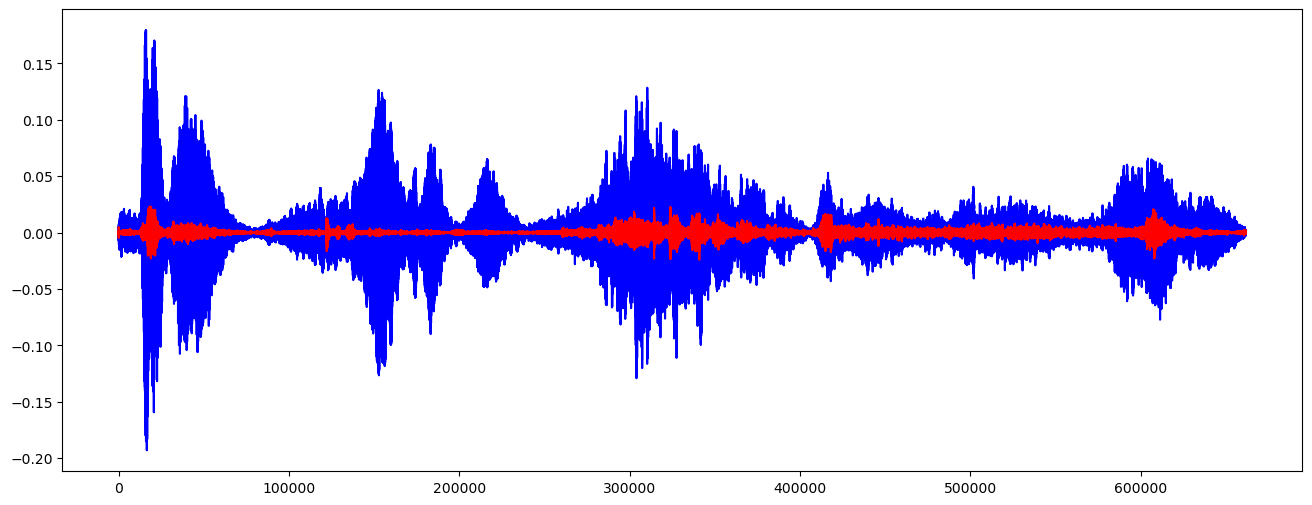

In [16]:
y_harm, y_perc = librosa.effects.hpss(y)
plt.figure(figsize=(16,6))
plt.plot(y_harm, color='b')
plt.plot(y_perc, color='r')
plt.show()

# 음악 장르를 구분하는데 사용됩니다.

Spectral Centroid
    -- 소리를 주파수 표현했을 떄, 주파수의 가중평균을 계산하여 소리의 "무게 중심"이 어딘지를 알려주는 지표
    -- 예를 들어, 블루스 음악은 무게 중심이 가운데 부분에 놓여있는 반면, 메탈 음악은 (끝 부분에서 달리기 때문에) 노래의 마지막 부분에 무게 중심이 실립니다.

C:\Users\smhrd\AppData\Local\Temp\ipykernel_1376\3380207109.py:1: FutureWarning: Pass y=[ 0.00167847  0.00393677  0.00320435 ... -0.00067139 -0.00082397
 -0.00091553] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spectral_centroids = librosa.feature.spectral_centroid(y, sr=sr)[0]


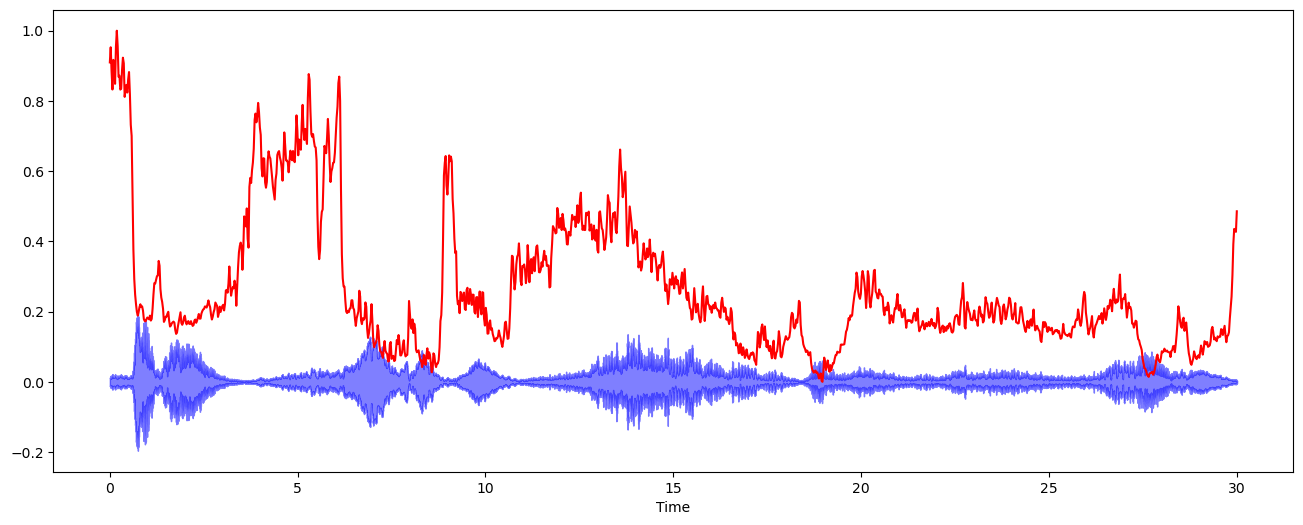

In [17]:
spectral_centroids = librosa.feature.spectral_centroid(y, sr=sr)[0]

# Computing the time variable for visualization
frames = range(len(spectral_centroids))

# Converts frame counts to time (seconds)
t = librosa.frames_to_time(frames)

import sklearn
def normalize(x, axis=0):
    return sklearn.preprocessing.minmax_scale(x, axis=axis)   # preprocessing 전처리 해서 0~1 사이로 나오게 하는 로직

plt.figure(figsize=(16,6))
librosa.display.waveshow(y, sr=sr, alpha=0.5, color='b')
plt.plot(t, normalize(spectral_centroids), color='r')
plt.show()

# 여기서 만들어지는 그래프는 파란색은 본래의 음파 진폭?? 이런것이고
# 붉은 색은 음악의 흐름에 따라 어디에 힘이 실리는지 확인 할 수 있다.

Spectral Rolloff
    - 신호 모양을 측정
    - 총 스펙트럼 에너지 중 낮은 주파수 (85% 이하) 에 얼마나 많이 집중되어 있는가를 확인 가능하다

C:\Users\smhrd\AppData\Local\Temp\ipykernel_1376\3058583797.py:1: FutureWarning: Pass y=[ 0.00167847  0.00393677  0.00320435 ... -0.00067139 -0.00082397
 -0.00091553] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  spectral_rolloff = librosa.feature.spectral_rolloff(y, sr=sr)[0]


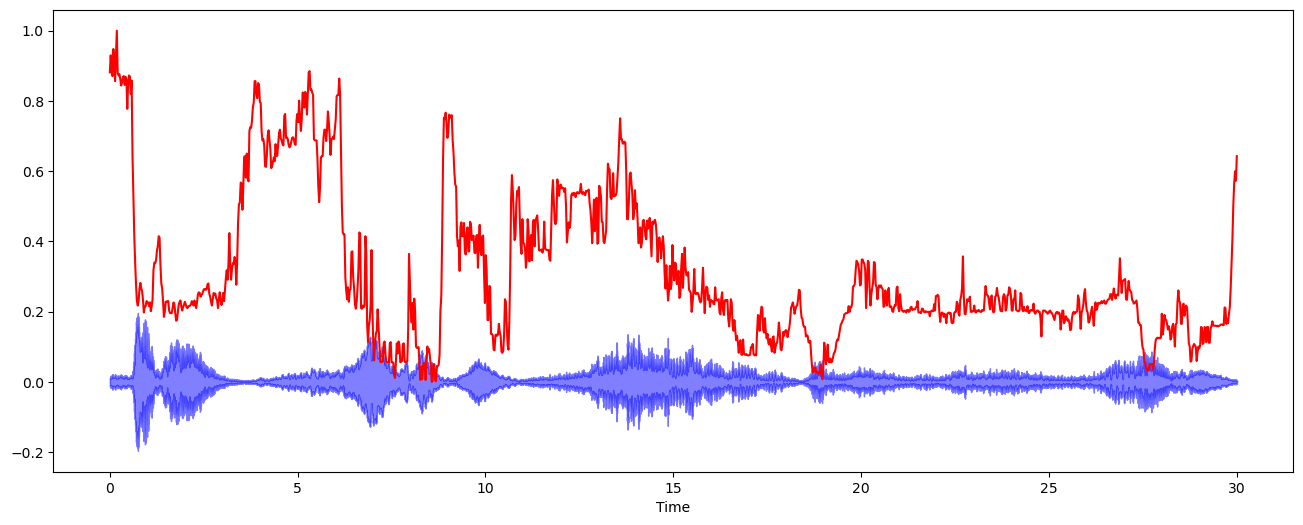

In [18]:
spectral_rolloff = librosa.feature.spectral_rolloff(y, sr=sr)[0]

plt.figure(figsize =(16,6))
librosa.display.waveshow(y, sr=sr, alpha=0.5, color='b')
plt.plot(t, normalize(spectral_rolloff), color='r')
plt.show()

# 위 그래프와 비슷하게 나타나고 이것도 자주 참조가 된다고 합니다.

### Mel-Frequency Cepstral Coefficients(MFCCs)

가장 중요한 특징이라고 합니다.

MFCCs는 특징들의 작은 집합(약 10~20)으로 스펙트럴 포곡선의 전체적인 모양을 축약해서 보여준다
사람의 청각 구조를 반영하여 음성 정보 추출
https://tech.kakaoenterprise.com/66

이것을 통해 ai에게 학습을 시켜주는 듯 싶습니다.

mean: 0.49
var: 0.04


C:\Users\smhrd\AppData\Local\Temp\ipykernel_1376\3015868229.py:1: FutureWarning: Pass y=[ 0.00167847  0.00393677  0.00320435 ... -0.00067139 -0.00082397
 -0.00091553] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(y, sr=sr)


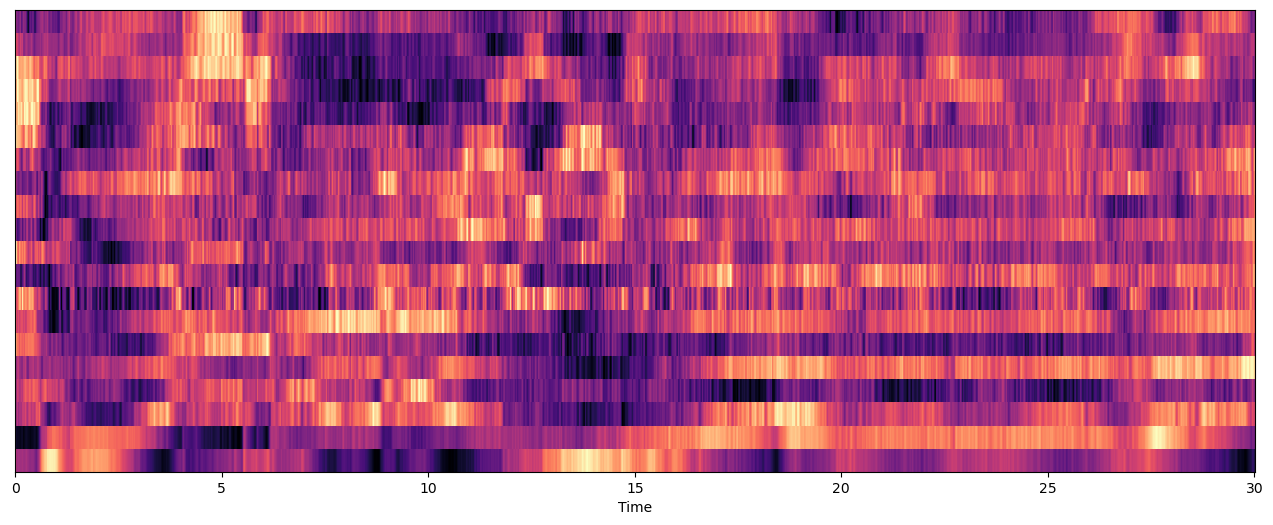

In [19]:
mfccs = librosa.feature.mfcc(y, sr=sr)
mfccs = normalize(mfccs, axis=1)

print('mean: %.2f' % mfccs.mean())   # mfcc의 평균값
print('var: %.2f' % mfccs.var())   # mfcc의 분산값

plt.figure(figsize=(16,6))
librosa.display.specshow(mfccs, sr=sr, x_axis='time')
plt.show()

Chroma Frequencies
    - 크로마 특징은 음악의 흥미롭고 강렬한 표현
    - 크로마는 인간 청각이 옥파브 차이가 나는 주파수를 가진 두 음을 유사음으로 인지한다는 음악이론에 기반
    - 모든 스펙트럼을 12개의 Bin으로 표현
    - 2개의 Bin은 옥타브에서 12개의 각기 다른 반응(Semitones = Chroma)을 의미한다

C:\Users\smhrd\AppData\Local\Temp\ipykernel_1376\1667389246.py:1: FutureWarning: Pass y=[ 0.00167847  0.00393677  0.00320435 ... -0.00067139 -0.00082397
 -0.00091553] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  chromagram = librosa.feature.chroma_stft(y, sr=sr, hop_length=512)


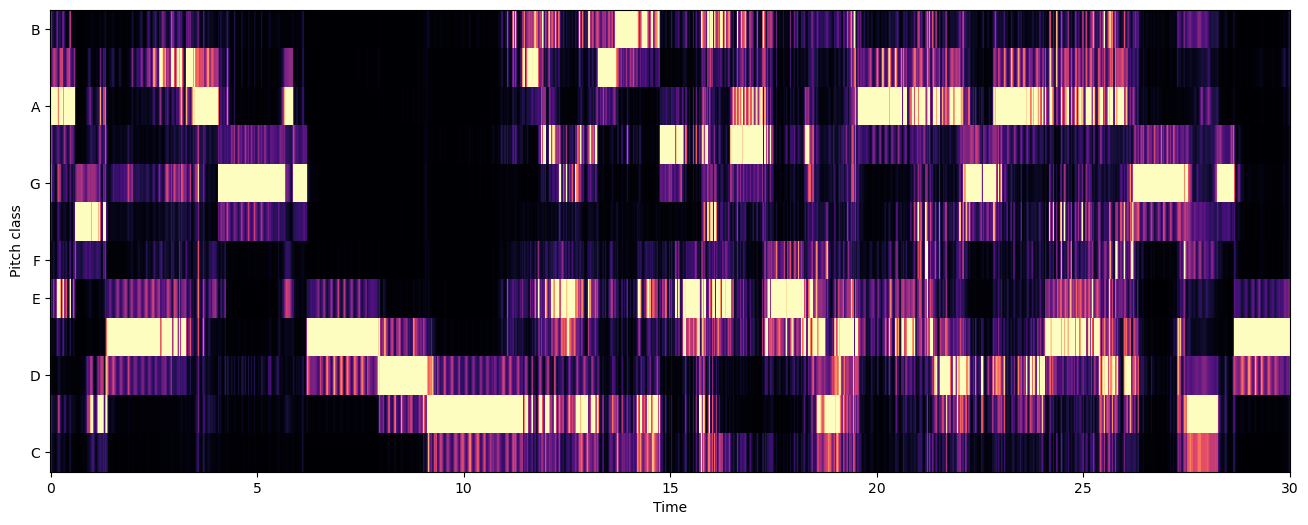

In [20]:
chromagram = librosa.feature.chroma_stft(y, sr=sr, hop_length=512)

plt.figure(figsize=(16,6))
librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', hop_length=512)
plt.show()

#### 기도 메타
- 이거 만든 사람도 알아서 잘 분류하겠지? 하는 마인드로 만들었다고 합니다... 매우 어렵네요

### 학습
#### 데이터셋 로드

In [21]:
import pandas as pd

df = pd.read_csv('Data/features_3_sec.csv')  # gtzan 데이터 받으면 포함되어있는 데이터

df.head() # 뭐가 있는가 봐봅시다.

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.0.wav,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,blues.00000.1.wav,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,blues.00000.2.wav,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
3,blues.00000.3.wav,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,...,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,blues.00000.4.wav,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,...,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues


In [22]:
#  전처리를 해보아요

X = df.drop(columns =['filename','length','label'])
# 여기서 label은 장르를 의미. 
y = df['label']
# 분석해서 label 즉 장르를 알아내는 작업을 할 계획

scaler = sklearn.preprocessing.MinMaxScaler()
np_scaled = scaler.fit_transform(X)

x = pd.DataFrame(np_scaled, columns=X.columns)

x.head()

,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,...,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var
0,0.355399,0.716757,0.293133,0.107955,0.262173,0.034784,0.459205,0.094130,0.346153,0.083164,...,0.363613,0.056198,0.397172,0.066062,0.371828,0.055344,0.380831,0.026797,0.506746,0.047781
1,0.367322,0.670347,0.253040,0.044447,0.270969,0.018716,0.470831,0.052261,0.363722,0.051694,...,0.468596,0.092912,0.351681,0.074001,0.362068,0.076365,0.418452,0.082414,0.593029,0.065548
2,0.373159,0.728067,0.296753,0.141663,0.265293,0.023073,0.494051,0.059922,0.378215,0.060820,...,0.479681,0.096704,0.420979,0.050639,0.400536,0.067509,0.433742,0.043841,0.546264,0.036062
3,0.399349,0.677066,0.298024,0.075042,0.238427,0.023187,0.455246,0.066234,0.329587,0.070906,...,0.386258,0.067995,0.387474,0.050617,0.380430,0.050030,0.405824,0.041898,0.562204,0.034873
4,0.355668,0.689113,0.322308,0.052149,0.233460,0.016451,0.451651,0.047830,0.318453,0.046916,...,0.438567,0.042500,0.460314,0.083860,0.388590,0.076524,0.409019,0.020763,0.517913,0.031713


### 데이터셋 분할

In [23]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=2021)
# 트레인 셋은 80%, 테스트 셋은 20%만 쓴다는 말이라는데요..?

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
# 데이터의 갯수를 출력하는 곳

(7992, 57) (7992,)
(1998, 57) (1998,)


#### 학습 및 검증
- xgboost는 설치해야하는 라이브러리라서 anaconda prompt 에
- pip install xgboost 입력하고 enter 누르면 설치가 됩니다.
- xgboost를 설치시 0.9 버전으로 합격해야 합니다.
- pip uninstall xgboost 
- pip install xgboost==0.90

In [24]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
# xgboost 가 성능이 아주 좋다고 합니다.

In [26]:
xgb = XGBClassifier(n_estimators=1000, learning_rate=0.05)
xgb.fit(X_train, y_train)
# 학습을 시작하게 하는 .fit()

y_preds = xgb.predict(X_test)
# 검증할 때 쓰는 .predict() 메소드 ... 결과값 넣기

print('Accuracy: %.2f' % accuracy_score(y_test, y_preds))
# 정답값과 예측 값에 대해 출력하게 하는 로직. 정확도에 대한 값이 출력된다는 듯?

Accuracy: 0.88


#### Confusion Matrix 그려보기
- 그리게 되면 가로측이 우리가 예측한 값
- 세로측이 정답값이 나오게 됩니다.
- 오답의 경우가 몇개 나오는데 bpm이나 이런걸로 다른 친구로 예측하는 경우가 있긴한데
- 높은 확률로 동일한 결과가 나오는 걸 확인가능하다. ( ai의 정확성에 대해서 파악할 때 쓰는듯?)

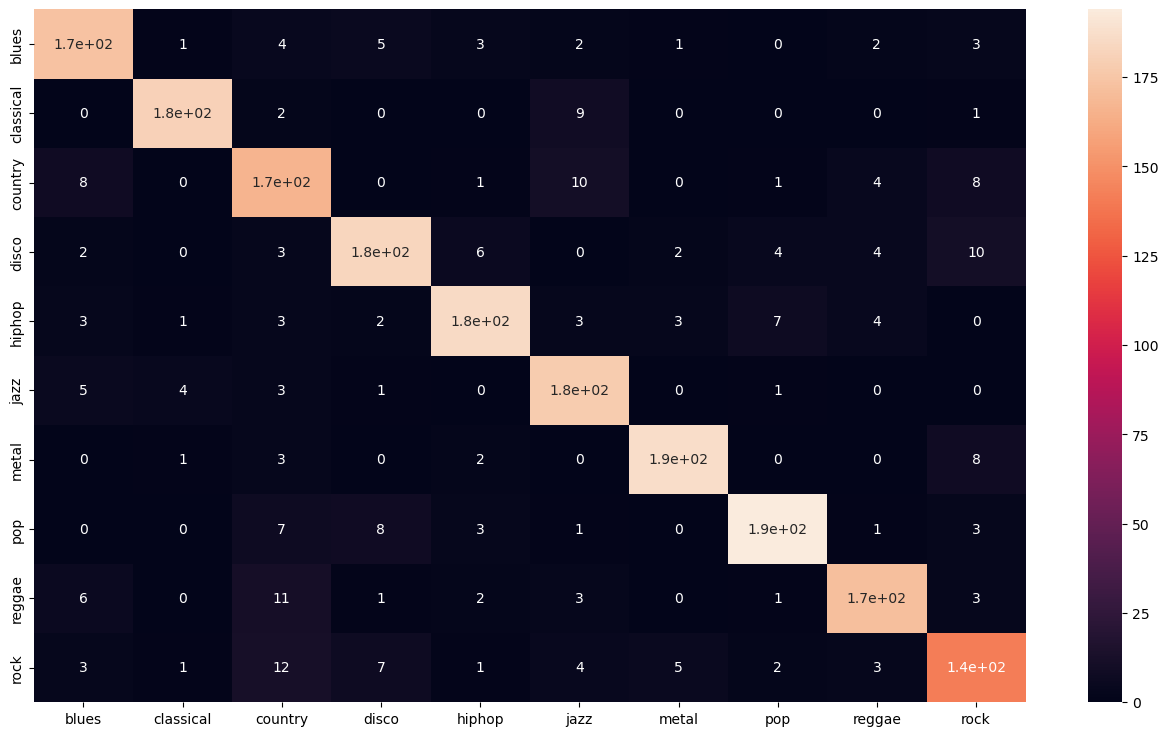

In [31]:
from sklearn.metrics import confusion_matrix
import seaborn as sns   # 얘는 내장라이브러리 인듯

cm = confusion_matrix(y_test, y_preds)

plt.figure(figsize=(16,9))
sns.heatmap(
    cm,
    annot=True,
    xticklabels=["blues","classical","country","disco","hiphop","jazz","metal","pop","reggae","rock"],
    yticklabels=["blues","classical","country","disco","hiphop","jazz","metal","pop","reggae","rock"]
)
plt.show()

In [34]:
for feature, importance in zip(X_test.columns, xgb.feature_importances_):
    print('%s: %.2f' % (feature, importance))

# feature, importance 개념 : 어떤 feature가 가장 중요한지를 알려주는 메소드?? 같은 아이.
# 특징에 따른 중요도를 알려주는데 특히 가장 중요한 점이 무엇인지 알려주는 것. 솔직히 쓸 일 없을듯;

chroma_stft_mean: 0.04
chroma_stft_var: 0.03
rms_mean: 0.02
rms_var: 0.03
spectral_centroid_mean: 0.02
spectral_centroid_var: 0.02
spectral_bandwidth_mean: 0.05
spectral_bandwidth_var: 0.01
rolloff_mean: 0.02
rolloff_var: 0.03
zero_crossing_rate_mean: 0.02
zero_crossing_rate_var: 0.01
harmony_mean: 0.02
harmony_var: 0.02
perceptr_mean: 0.02
perceptr_var: 0.08
tempo: 0.02
mfcc1_mean: 0.02
mfcc1_var: 0.03
mfcc2_mean: 0.01
mfcc2_var: 0.01
mfcc3_mean: 0.01
mfcc3_var: 0.02
mfcc4_mean: 0.04
mfcc4_var: 0.02
mfcc5_mean: 0.01
mfcc5_var: 0.03
mfcc6_mean: 0.02
mfcc6_var: 0.01
mfcc7_mean: 0.01
mfcc7_var: 0.03
mfcc8_mean: 0.01
mfcc8_var: 0.01
mfcc9_mean: 0.02
mfcc9_var: 0.01
mfcc10_mean: 0.01
mfcc10_var: 0.01
mfcc11_mean: 0.01
mfcc11_var: 0.01
mfcc12_mean: 0.03
mfcc12_var: 0.01
mfcc13_mean: 0.01
mfcc13_var: 0.01
mfcc14_mean: 0.01
mfcc14_var: 0.01
mfcc15_mean: 0.01
mfcc15_var: 0.01
mfcc16_mean: 0.01
mfcc16_var: 0.01
mfcc17_mean: 0.01
mfcc17_var: 0.00
mfcc18_mean: 0.01
mfcc18_var: 0.01
mfcc19_mean: 0

### 빵형 유튭에서 알려주는 간단한 추천 시스템
- 코사인 유사도를 통해서 알려주는 듯합니다.

In [36]:
df_30 = pd.read_csv('Data/features_30_sec.csv', index_col='filename')
# 다운받은 폴더에서 불러오고.

labels = df_30[['label']]
df_30 = df_30.drop(columns=['length','label'])
# 둘은 빠져야 함. -> 오디오의 feature만을 사용해서 추천한다는 가정하에
# 그렇다면 이런식으로 다 가야하나??? feature만 알아내는?
# 우리가 받아오는 음원에는 feature가 다 들어있는가? 음원 파일식으로 어떻게 받아오는가

df_30_scaled = sklearn.preprocessing.scale(df_30)

df_30 = pd.DataFrame(df_30_scaled, columns=df_30.columns)

df_30.head()

,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,...,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var
0,-0.350137,0.312587,-0.010690,-0.061856,-0.583585,-0.848311,-0.456402,-0.531042,-0.486473,-0.661934,...,-0.086396,-0.246114,0.500462,-0.780265,-0.237040,-0.643177,0.006723,-0.300597,0.604064,-0.512988
1,-0.462482,1.117572,-0.532852,-0.186821,-0.938516,-0.234194,-0.386852,0.796252,-0.648681,0.795823,...,-0.048102,-0.159175,0.711371,-0.069304,-0.054982,-0.453456,0.544806,-0.407087,0.424127,-0.538421
2,-0.184225,-0.137701,0.679978,-0.084093,-0.906885,-0.781694,-0.940663,-0.630916,-0.971592,-0.744406,...,0.284825,-0.596243,-0.827516,-0.448091,-0.600983,-0.329519,-0.295934,-0.527297,-0.296189,-0.874954
3,0.319639,0.990659,0.154810,0.907029,-1.581429,-0.712095,-1.228256,0.304565,-1.516390,-0.246530,...,-0.080249,-0.482843,0.142153,-0.371370,0.033427,-0.767591,0.455409,-0.779744,-0.602881,-0.844508
4,-0.859077,0.194163,-0.600165,-0.205909,-0.512542,-0.315178,-0.939770,-0.504463,-0.630107,-0.190517,...,-1.238616,0.751318,-0.327220,0.377620,-0.368375,-0.293696,-0.553016,-0.089383,-2.766009,-0.330287


In [37]:
from sklearn.metrics.pairwise import cosine_similarity # 얘도 바로 import 가능

similarity = cosine_similarity(df_30)
# 전처리한 데이터만 넣어주면 알아서 처리해준다.

sim_df = pd.DataFrame(similarity, index=labels.index, columns=labels.index)
# 가로 세로가 전부 음악을 index한 곡들이 나오고 각 곡들 별로 코사인 유사도를 알려주게 됩니다.
# 상당히 신기합니다. 해보세요 심심할 때

sim_df.head()

# 이부분은 코사인 유사도를 통해 백터값을 알아내고 백터값이 1에 가까울수록 비슷한 음악임을
# -1에 가까울 수록 전혀 다른 음악임을 나타냅니다.

filename,blues.00000.wav,blues.00001.wav,blues.00002.wav,blues.00003.wav,blues.00004.wav,blues.00005.wav,blues.00006.wav,blues.00007.wav,blues.00008.wav,blues.00009.wav,...,rock.00090.wav,rock.00091.wav,rock.00092.wav,rock.00093.wav,rock.00094.wav,rock.00095.wav,rock.00096.wav,rock.00097.wav,rock.00098.wav,rock.00099.wav
filename,,,,,,,,,,,,,,,,,,,,,
blues.00000.wav,1.000000,0.049231,0.589618,0.284862,0.025561,-0.346688,-0.219483,-0.167626,0.641877,-0.097889,...,-0.082829,0.546169,0.578558,0.662590,0.571629,0.610942,0.640835,0.496294,0.284958,0.304098
blues.00001.wav,0.049231,1.000000,-0.096834,0.520903,0.080749,0.307856,0.318286,0.415258,0.120649,0.404168,...,-0.098111,-0.325126,-0.370792,-0.191698,-0.330834,-0.077301,-0.222119,-0.302573,0.499562,0.311723
blues.00002.wav,0.589618,-0.096834,1.000000,0.210411,0.400266,-0.082019,-0.028061,0.104446,0.468113,-0.132532,...,-0.032408,0.561074,0.590779,0.583293,0.514537,0.495707,0.566837,0.589983,0.216378,0.321069
blues.00003.wav,0.284862,0.520903,0.210411,1.000000,0.126437,0.134796,0.300746,0.324566,0.352758,0.295184,...,-0.320107,-0.206516,-0.151132,0.041986,-0.172515,-0.000287,0.020515,-0.107821,0.502279,0.183210
blues.00004.wav,0.025561,0.080749,0.400266,0.126437,1.000000,0.556066,0.482195,0.623455,0.029703,0.471657,...,0.087605,0.017366,0.138035,0.104684,-0.034594,0.063454,0.063546,0.172944,0.153192,0.061785


In [39]:
# find_similar_songs 함수 정의하기!
def find_similar_songs(name, n=5):
    series = sim_df[name].sort_values(ascending=False)
    
    series = series.drop(name)
    
    return series.head(n).to_frame()
    # 매개변수에 들어갈 친구와 가장 비슷한 노래 5곡을 추천해 달라는 함수
    # 여기서 n은 강사님들한테 받은 top_n 이랑 같은 부분이고 name에는 저장된 곡명을 넣으면 된다.
    
find_similar_songs('rock.00000.wav')
# rock.0000 이라는 음원파일과 가장 유사도가 높은 곡 5개를 추천해달라! 는 의미
# 거의다 같은 장르가 출력되지만 한번씩 비슷한 느낌의 다른 장르의 곡이 출력되기도 합니다.

,rock.00000.wav
filename,
rock.00079.wav,0.681819
rock.00026.wav,0.677842
country.00070.wav,0.675324
rock.00064.wav,0.662020
rock.00096.wav,0.654814


### 그래서 어떻게?
#### 이걸 어떻게 대입할지 고민해봐야 하는 데  문제점이 있습니다.
#### 음악파일 (재생이 가능한) 친구를 바탕으로 feature를 추출해서 그 feature를 바탕으로 코사인 유사도를 찾는 작업을 반복하는 것인데 음원파일을 어떻게 받아오는가? 
#### 크롤링해서 받아오는 것이 음원파일을 대체할 수 있는가?
#### 일단 가서 데이터 다운받아서 폴더별 음원파일에 특징을 아라보자